In [2]:
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_decision_regions
import random
from sklearn.tree import plot_tree
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

In [20]:
class AdaBoost(object):
    def __init__(self):
        pass
        
    def _train_classifier(self, X, y):
        dt = DecisionTreeClassifier(max_depth=1)
        dt.fit(X,y)
        return dt.predict(X), dt
        
    def _calculate_model_weight(self,error):
        return 0.5 * np.log((1-error)/error + 0.000001)

    def _get_alpha(self,df_, pred):
        df_['y_pred'] = pred
        error =  df_.query("y != y_pred")['weights'].sum()
        alpha = self._calculate_model_weight(error)
        return alpha, error

    def _update_row_weights(self, row, alpha):

        if row['y'] == row['y_pred']:
            return row['weights'] * np.exp(-alpha)
        else:
            return row['weights'] * np.exp(alpha)
    def _create_new_dataset_indices(self, df_):
        rand_values = np.random.random(len(df_))
        selected_indices = []
        for index, row in df_.iterrows():
            rand = np.random.random()
            for i, row in df_.iterrows():
                if row['cumsum_lower'] < rand and rand  <= row['cumsum_upper']:
                    selected_indices.append(i)
        return selected_indices
    def _get_alpha_and_updated_df(self, df_, column_names, label_column):
        """
        """
        X = df_[column_names].values 
        y = df_[label_column].values
        pred, dt = self._train_classifier(X, y)
        alpha, error = self._get_alpha(df_, pred)
        df_['updated_weights'] = df_['weights'] * np.exp(alpha * (df_['y'] != df_['y_pred']).apply(lambda x: 1 if x else -1))

        #df_['updated_weights'] = df_.apply(self._update_row_weights,alpha=alpha, axis=1)
        df_['normalized_weights'] = df_['updated_weights']/df_['updated_weights'].sum()
        df_['cumsum_upper'] = np.cumsum(df_['normalized_weights'])
        df_['cumsum_lower'] = df_['cumsum_upper'] - df_['normalized_weights']
        selected_indices = self._create_new_dataset_indices(df_)

        selected_columns = column_names + [label_column] + ['weights']
        updated_df = df_.loc[selected_indices, selected_columns]
        return dt, alpha, updated_df, X, y, error
    def train_ada_boost(self, num_stumps, df__, column_names, label_column):
        dts = []
        alphas = []
        df__['weights'] =  1/df__.shape[0]
        for i in range(num_stumps):

            dt, alpha, df__, _, _ , error= self._get_alpha_and_updated_df(df__, column_names, label_column)
            print(f"Stump {i + 1}: Alpha = {alpha:.4f}, Error = {error:.4f}")
            dts.append(dt)
            alphas.append(alpha)
        return dts, alphas

    def get_prediction(self, alphas, query, dts):
        res = 0
        for i, alpha in enumerate(alphas):
            dt = dts[i]
            y_pred = dt.predict(query)
            res += alpha*y_pred
        return np.sign(res)
        
            


# Create a random dataset

In [25]:
df = pd.DataFrame({'x1':range(0, 10),'x2':[random.randint(1, 10) for _ in range(10)], 'y':[random.randint(0, 1)  for _ in range(10)]})

In [26]:
df.head()

,x1,x2,y
0,0,2,0
1,1,5,0
2,2,2,0
3,3,1,1
4,4,9,0


In [27]:
#sns.scatterplot(x=df['x1'], y = df['x2'], hue=df['y'])

In [28]:
num_stumps = 3
column_names = ['x1', 'x2']
label_column = 'y'
ada_boost = AdaBoost()
dts, alphas = ada_boost.train_ada_boost(num_stumps, df, column_names, label_column)

Stump 1: Alpha = 0.6931, Error = 0.2000
Stump 2: Alpha = 1.0986, Error = 0.1000
Stump 3: Alpha = 0.4236, Error = 0.3000


In [14]:
query = np.array([0,7]).reshape(1,2)
ada_boost.get_prediction(alphas, query, dts)

array([1.])

## We can anayse decision  trees 🌳 🌴  🌲  one by one

In [148]:
dt3, alpha3, df4,  X3, y3 = get_alpha_and_updated_df(df3)

[Text(0.5, 0.75, 'x[0] <= 0.5\ngini = 0.42\nsamples = 10\nvalue = [3, 7]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]')]

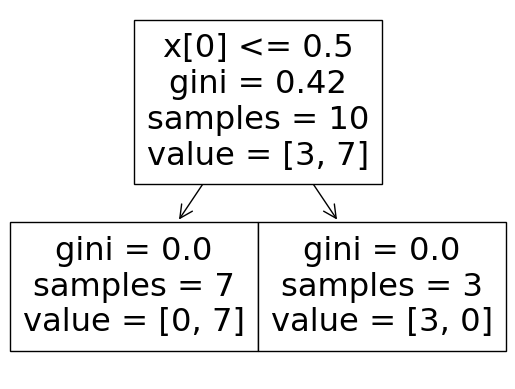

In [149]:
plot_tree(dt3)

<Axes: >

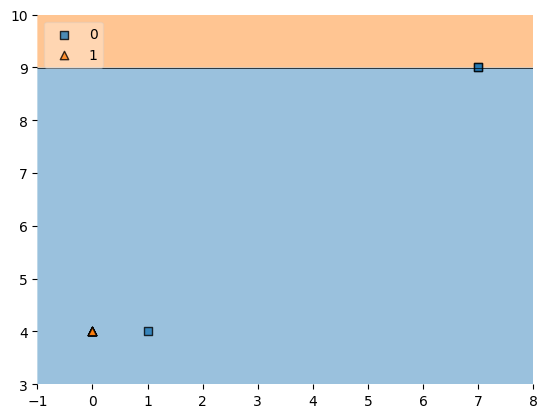

In [150]:
plot_decision_regions(X3, y3, dt1, legend=2)